# Capstone Project : Recruit Restaurant Visitor Forecasting

### Domain Background:
* This project is derived from time series forecast. The data holds the following information for 829 restaurants in Japan which includes restaurant's id which is unique for each restaurant, date, No of visitors on those dates, restaurant genre and area name and its location using latitude and longitude. This data are time series forecast because here Input is Time(it can be date and time or onlydate) and output is no of visitors. In this, order of data are important ,change in order will result in poor forecast. For example if the order of no of visitors in that column is changed and train the model with those un ordered data will result in wrong forecast on those days. So ordering is important that is crucial in time series data. Solving this visitors forecast problem makes restaurnat to effectively plan on scheduling staff members and purchasing ingredients, which in turn will reduce loss and it will help restaurants to be much more efficient and allow them to focus on creating an enjoyable dining experience for their customers. The reason I chose this capstone because when I owned a restaurant, and not knowing the approximate no of visitors at the intial year had led to ineffecient staff planning and buying ingredients which leads to loss. But later years I have used historical data and information about holidays and was able to guess the no of visitors which helped me to reduce the loss significantly. Building models using historical data, location, genre, holidays, would help to better approximate no of visitors.

### Problem Statement:
    * In this project, I would forecast 'No of visitors a restaurant will recieve in future'. The problem here is time series where time as input and no of visitors as Output. But I would convert the time series problem into supervised learning problem where instead of giving time as input to model I would use previous month's day of week average on no of visitors as input and no of visitors on each day as output which is strongly correlated than giving just time as input. This conversion still maintains the order by replacing time with with average no of customers. This conversion leads to approach this problem as supervised machine learning regression problem.

### Project Design: 
The following steps are planned to solve this problem

Importing the dataset
Merging relevant files with training data and convert the data to relevant datatypes.
Perform Feature Engineering - for instance: extracting day of week, month, week of the year information from date column
Filter the no of visitors on training data with no holidays and compute every month day of week average using groupby in pandas.
Performing time series to supervised learning using groupby pandas and helper method so that previous month day of week average would be computed and merged with training dataset.
Preparing train and test data set which includes following fields as input restuarant id, month,dow, previous month average(which we got by helper method), genre,areaname,holiday_flag(bcoz the previous month average computed on days with no holiday),latitude,longitude as inputs and no of visitors as output. Same with testing data but no of visitor column will be zero need to be predicted. 7.Split the training data into train and test split to evaluate the model. 8.Using sklearn libraries, implement KNN, SVM and Random Forest model. 9.Measure the performance of model with test set of training data using RMSE metrics. If the value is closer to zero or negative means the model is better model.Based on RMSE value decide the better model. 10.Once the model is finalized then train the model using the whole training data and perform prediction on the test data where no of visitors are zero and need to be predicted.

Data Exploration:
  1. Importing the data set
  2. Datatype conversion to relevant datatype
  3. merging the dataframes 
Feature enginnering
conversion of timeseries dataset into supervised machine learning problem
Preparing training and test data set
Handling missing values
Benchmark Algorithm and its implementation
Algorithm relevant to this problem and its implementation
Parameter tuning using gridsearch Cv
Evaluation metrics
Model Evaluation
Forecasting with new data set.

### 1.Importing dataset and libraries

### Importing libraries:
  Pandas and Numpy libraries are used to handle the data and perform mathematical operation on data.
  Sklearn libraries are used for scaling encodeing and implementing machine learning model
  

In [4]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import mean_squared_error

###  Importing Data set:
    Hot Pepper Gourmet (hpg): similar to Yelp, here users can search restaurants and also make a reservation online 
    AirREGI / Restaurant Board (air): similar to Square, a reservation control and cash register system 
    You must use the reservations, visits, and other information from these sites to forecast future restaurant visitor totals on a given date. The training data covers the dates from 2016 until April 2017. 
    The test set covers the last week of April and May of 2017. The test set is split based on time (the public fold coming first, the private fold following the public) and covers a chosen subset of the air restaurants. Note that the test set intentionally spans a holiday week in Japan called the "Golden Week."

    There are days in the test set where the restaurant were closed and had no visitors. These are ignored in scoring. The training set omits days where the restaurants were closed.

    File Descriptions This is a relational dataset from two systems. Each file is prefaced with the source (either air or hpg) to indicate its origin. Each restaurant has a unique air_store_id and hpg_store_id. 
   
   CSV files are converted into dataframe using pandas and 
    Each data frame is stored as value in dictionary where key is name of the dataframe. 
    eg:
    air_visit_Data.csv is converted into dataframe using pd.read_csv(sep=',') and stored under name tra which act as key in dictionary and the dataframe is the value. Using the key will be able to access the data frame.

In [5]:
# dictionary is created with values as data frame using pd.read_csv()
data = {
    'tra': pd.read_csv('restaurant_data/air_visit_data.csv'),
    'as': pd.read_csv('restaurant_data/air_store_info.csv'),
    'hs': pd.read_csv('restaurant_data/hpg_store_info.csv'),
    'ar': pd.read_csv('restaurant_data/air_reserve.csv'),
    'hr': pd.read_csv('restaurant_data/hpg_reserve.csv'),
    'id': pd.read_csv('restaurant_data/store_id_relation.csv'),
    'tes': pd.read_csv('restaurant_data/sample_submission.csv'),
    'hol': pd.read_csv('restaurant_data/date_info.csv').rename(columns={'calendar_date':'visit_date'})
    }
#merging the id and hr data frame to find the air_store_id of that restaurant
data['hr'] = pd.merge(data['hr'], data['id'], how='inner', on=['hpg_store_id'])
data['hr'].drop('hpg_store_id',  axis=1, inplace=True)
data['ar'] = data['ar'].append(data['hr'])


**air_visit_data.csv** - This file contain air_Store_id,visit_date and no of visitors to those restaurant. This file contain training examples

In [3]:
data['tra'].head()

,air_store_id,visit_date,visitors
0,air_ba937bf13d40fb24,2016-01-13,25
1,air_ba937bf13d40fb24,2016-01-14,32
2,air_ba937bf13d40fb24,2016-01-15,29
3,air_ba937bf13d40fb24,2016-01-16,22
4,air_ba937bf13d40fb24,2016-01-18,6


**air_store_info.csv:**
This file contains information about select air restaurants. Column names and contents are self-explanatory.
air_store_id air_genre_name air_area_name latitude longitude Note: latitude and longitude are the latitude and longitude of the area to which the store belongs

In [4]:
data['as'].head()

,air_store_id,air_genre_name,air_area_name,latitude,longitude
0,air_0f0cdeee6c9bf3d7,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852
1,air_7cc17a324ae5c7dc,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852
2,air_fee8dcf4d619598e,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852
3,air_a17f0778617c76e2,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852
4,air_83db5aff8f50478e,Italian/French,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599


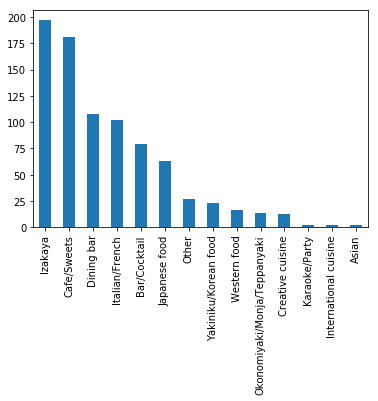

In [5]:
data['as'].air_genre_name.value_counts().plot(kind='bar')

**air_reserve.csv:** 
This file contains reservations made in the air system. It includes following fields
air_store_id - the restaurant's id in the air system 
visit_datetime - the time of the reservation visitor will occur 
reserve_datetime - the time the reservation was made 
reserve_visitors - the number of visitors for that reservation 

In [6]:
data['ar'].head()

,air_store_id,reserve_datetime,reserve_visitors,visit_datetime
0,air_877f79706adbfb06,2016-01-01 16:00:00,1,2016-01-01 19:00:00
1,air_db4b38ebe7a7ceff,2016-01-01 19:00:00,3,2016-01-01 19:00:00
2,air_db4b38ebe7a7ceff,2016-01-01 19:00:00,6,2016-01-01 19:00:00
3,air_877f79706adbfb06,2016-01-01 16:00:00,2,2016-01-01 20:00:00
4,air_db80363d35f10926,2016-01-01 01:00:00,5,2016-01-01 20:00:00


**hpg_store_info.csv:** 
This file contains information about select hpg restaurants. Column names and contents are self-explanatory.
hpg_store_id hpg_genre_name hpg_area_name latitude longitude Note: latitude and longitude are the latitude and longitude of the area to which the store belongs

In [7]:
data['hs'].head()

,hpg_store_id,hpg_genre_name,hpg_area_name,latitude,longitude
0,hpg_6622b62385aec8bf,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221
1,hpg_e9e068dd49c5fa00,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221
2,hpg_2976f7acb4b3a3bc,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221
3,hpg_e51a522e098f024c,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221
4,hpg_e3d0e1519894f275,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221


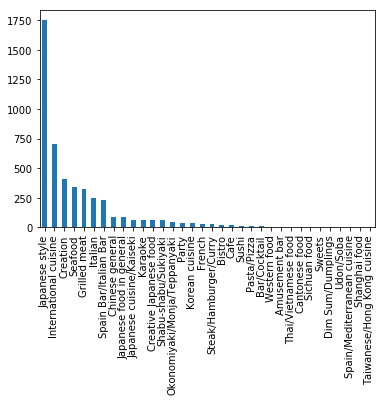

In [10]:
data['hs'].hpg_genre_name.value_counts().plot(kind='bar')

**hpg_reserve.csv:**
This file contains reservations made in the hpg system.
hpg_store_id - the restaurant's id in the hpg system 
visit_datetime - the time of the reservation 
reserve_datetime - the time the reservation was made
reserve_visitors - the number of visitors for that reservation 

In [11]:
data['hr'].head()

,visit_datetime,reserve_datetime,reserve_visitors,air_store_id
0,2016-01-01 19:00:00,2016-01-01 15:00:00,4,air_db80363d35f10926
1,2016-01-02 19:00:00,2016-01-02 14:00:00,2,air_db80363d35f10926
2,2016-01-03 18:00:00,2016-01-02 20:00:00,6,air_db80363d35f10926
3,2016-01-06 20:00:00,2016-01-04 22:00:00,3,air_db80363d35f10926
4,2016-01-11 18:00:00,2016-01-11 14:00:00,2,air_db80363d35f10926


**store_id_relation.csv:** 
This file allows you to join select restaurants that have both the air and hpg system.
hpg_store_id air_store_id air_visit_data.csv This file contains historical visit data for the air restaurants.

In [12]:
data['id'].head()

,air_store_id,hpg_store_id
0,air_63b13c56b7201bd9,hpg_4bc649e72e2a239a
1,air_a24bf50c3e90d583,hpg_c34b496d0305a809
2,air_c7f78b4f3cba33ff,hpg_cd8ae0d9bbd58ff9
3,air_947eb2cae4f3e8f2,hpg_de24ea49dc25d6b8
4,air_965b2e0cf4119003,hpg_653238a84804d8e7


**sample_submission.csv:**
This file shows a submission in the correct format, including the days for which you must forecast.This is the testing file.
id - the id is formed by concatenating the air_store_id and visit_date with an underscore visitors- the number of visitors forecasted for the store and date combination 

In [14]:
data['tes'].head()

,id,visitors
0,air_00a91d42b08b08d9_2017-04-23,0
1,air_00a91d42b08b08d9_2017-04-24,0
2,air_00a91d42b08b08d9_2017-04-25,0
3,air_00a91d42b08b08d9_2017-04-26,0
4,air_00a91d42b08b08d9_2017-04-27,0


**date_info.csv:**
This file gives basic information about the calendar dates in the dataset.
calendar_date, day_of_week are self explanatory.
holiday_flg - is the day a holiday in Japan 

In [13]:
data['hol'].head()

,visit_date,day_of_week,holiday_flg
0,2016-01-01,Friday,1
1,2016-01-02,Saturday,1
2,2016-01-03,Sunday,1
3,2016-01-04,Monday,0
4,2016-01-05,Tuesday,0


### 2.Datatype conversion

1. Converting the string into pandas datetime format.
2. Finding difference between reserve_datetime and visit_datetime of ar and hr dataframe on each row and groupy based on restaurant id and visitdate to find the total no of reserve visitors for each restaurant.  


In [6]:
for df in ['ar','hr']:
    data[df]['visit_datetime'] = pd.to_datetime(data[df]['visit_datetime'])
    data[df]['visit_datetime'] = data[df]['visit_datetime'].dt.date
    data[df]['reserve_datetime'] = pd.to_datetime(data[df]['reserve_datetime'])
    data[df]['reserve_datetime'] = data[df]['reserve_datetime'].dt.date    
    data[df]['reserve_datetime_diff'] = data[df].apply(lambda r: (r['visit_datetime'] - r['reserve_datetime']).days, axis=1)
    data[df] = data[df].groupby(['air_store_id','visit_datetime'], as_index=False)[['reserve_datetime_diff', 'reserve_visitors']].sum().rename(columns={'visit_datetime':'visit_date'})

In [16]:
data['ar'].head()

,air_store_id,visit_date,reserve_datetime_diff,reserve_visitors
0,air_00a91d42b08b08d9,2016-01-14,3,2
1,air_00a91d42b08b08d9,2016-01-15,6,4
2,air_00a91d42b08b08d9,2016-01-16,3,2
3,air_00a91d42b08b08d9,2016-01-22,3,2
4,air_00a91d42b08b08d9,2016-01-29,6,5


### 3.Perform Feature engineering:
1. Extracting day of week, year,month, date part of time stamp from visit_date of training and testing dataframes.
2. To match the features in both training and testing dataset, air_store_id in testing dataframe is concatenation of id and visit date , extracting visit_date and id from that air_store_id column of testing dataframe.
3.Convert the string data type into numeric datatype for categorical variable using LabelEncoder()


In [7]:
data['tra']['visit_date'] = pd.to_datetime(data['tra']['visit_date'])
data['tra']['dow'] = data['tra']['visit_date'].dt.dayofweek
data['tra']['year'] = data['tra']['visit_date'].dt.year
data['tra']['month'] = data['tra']['visit_date'].dt.month
data['tra']['visit_date'] = data['tra']['visit_date'].dt.date

data['tes']['visit_date'] = data['tes']['id'].map(lambda x: str(x).split('_')[2])
data['tes']['air_store_id'] = data['tes']['id'].map(lambda x: '_'.join(x.split('_')[:2]))
data['tes']['visit_date'] = pd.to_datetime(data['tes']['visit_date'])
data['tes']['dow'] = data['tes']['visit_date'].dt.dayofweek
data['tes']['year'] = data['tes']['visit_date'].dt.year
data['tes']['month'] = data['tes']['visit_date'].dt.month
data['tes']['visit_date'] = data['tes']['visit_date'].dt.date

In [8]:
encoder=LabelEncoder()
data['hol']['visit_date']=pd.to_datetime(data['hol']['visit_date'])
data['hol']['day_of_week']=encoder.fit_transform(data['hol']['day_of_week'])
data['hol']['visit_date']=data['hol']['visit_date'].dt.date

### 4.Data preparation for training and testing:
1. Merging training and testing dataframe with holiday dataframe using left join on column visit_date.
2. Checking whether holiday affects no of visitors
3. Checking the distibution of no of visitors and if it not normal then taking logarthim to convert the exponential distribution to normal.

In [9]:
# merging training and holiday data frame using left join 
temp=pd.merge(data['tra'],data['hol'],how='left',on=['visit_date'])


In [10]:
#summary statistic of target variable during working days
temp[temp.holiday_flg==0]['visitors'].describe()

count    239333.000000
mean         20.828064
std          16.624503
min           1.000000
25%           9.000000
50%          17.000000
75%          29.000000
max         877.000000
Name: visitors, dtype: float64

In [11]:
#summary statistic of target variable during holidays
temp[temp.holiday_flg==1]['visitors'].describe()

count    12775.000000
mean        23.703327
std         18.863804
min          1.000000
25%         10.000000
50%         19.000000
75%         33.000000
max        205.000000
Name: visitors, dtype: float64

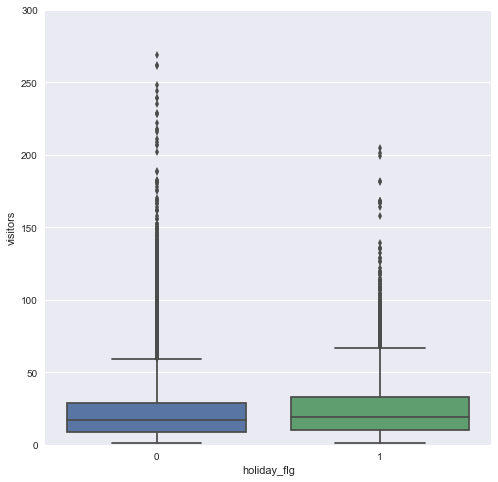

In [12]:
#plotting summary statistics of target variable during holidays and working days
import seaborn as sns
plt.figure(figsize=(8,8))
plt.subplot(111)
plt.ylim(0,300)
sns.boxplot(temp.holiday_flg,temp.visitors)


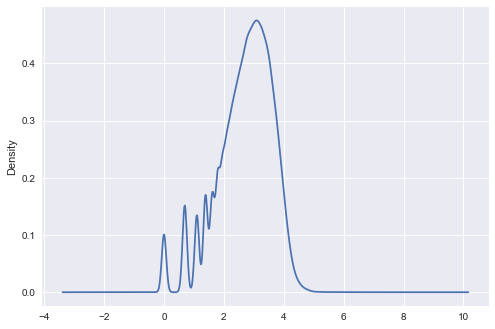

In [13]:
# nullify the effect of extreme values taking log-transformation
temp['log_visitors']=np.log(temp['visitors'])
#plotting to find the distribution after log-transformation
temp.log_visitors.plot(kind='kde')

In [14]:
temp.head()

,air_store_id,visit_date,visitors,dow,year,month,day_of_week,holiday_flg,log_visitors
0,air_ba937bf13d40fb24,2016-01-13,25,2,2016,1,6,0,3.218876
1,air_ba937bf13d40fb24,2016-01-14,32,3,2016,1,4,0,3.465736
2,air_ba937bf13d40fb24,2016-01-15,29,4,2016,1,0,0,3.367296
3,air_ba937bf13d40fb24,2016-01-16,22,5,2016,1,2,0,3.091042
4,air_ba937bf13d40fb24,2016-01-18,6,0,2016,1,1,0,1.791759


**Checking weather holiday affect no of visitors:**
1. Temp dataframe is formed by feature engineering on training dataframe and merging the holiday flag from holiday dataframe
2.Finding average no of visitors of each restaurant based on holiday flag using pandas.groupby()
3.Visualizing the variation using bar plot. The reason for using bar plot is X axis is categorical variable(ie holiday_flag 0 or 1 )for each restaurant.


In [15]:

#checking 
visitor_cnt_hold=temp.groupby(['air_store_id','holiday_flg'],as_index=False)['visitors'].mean()
visitor_cnt=visitor_cnt_hold.pivot_table(values='visitors',index='air_store_id',columns='holiday_flg')
visitor_cnt.head()

holiday_flg,0,1
air_store_id,,
air_00a91d42b08b08d9,26.103896,21.000000
air_0164b9927d20bcc3,9.291667,8.000000
air_0241aa3964b7f861,9.883905,10.176471
air_0328696196e46f18,7.981818,7.166667
air_034a3d5b40d5b1b1,14.855932,14.400000


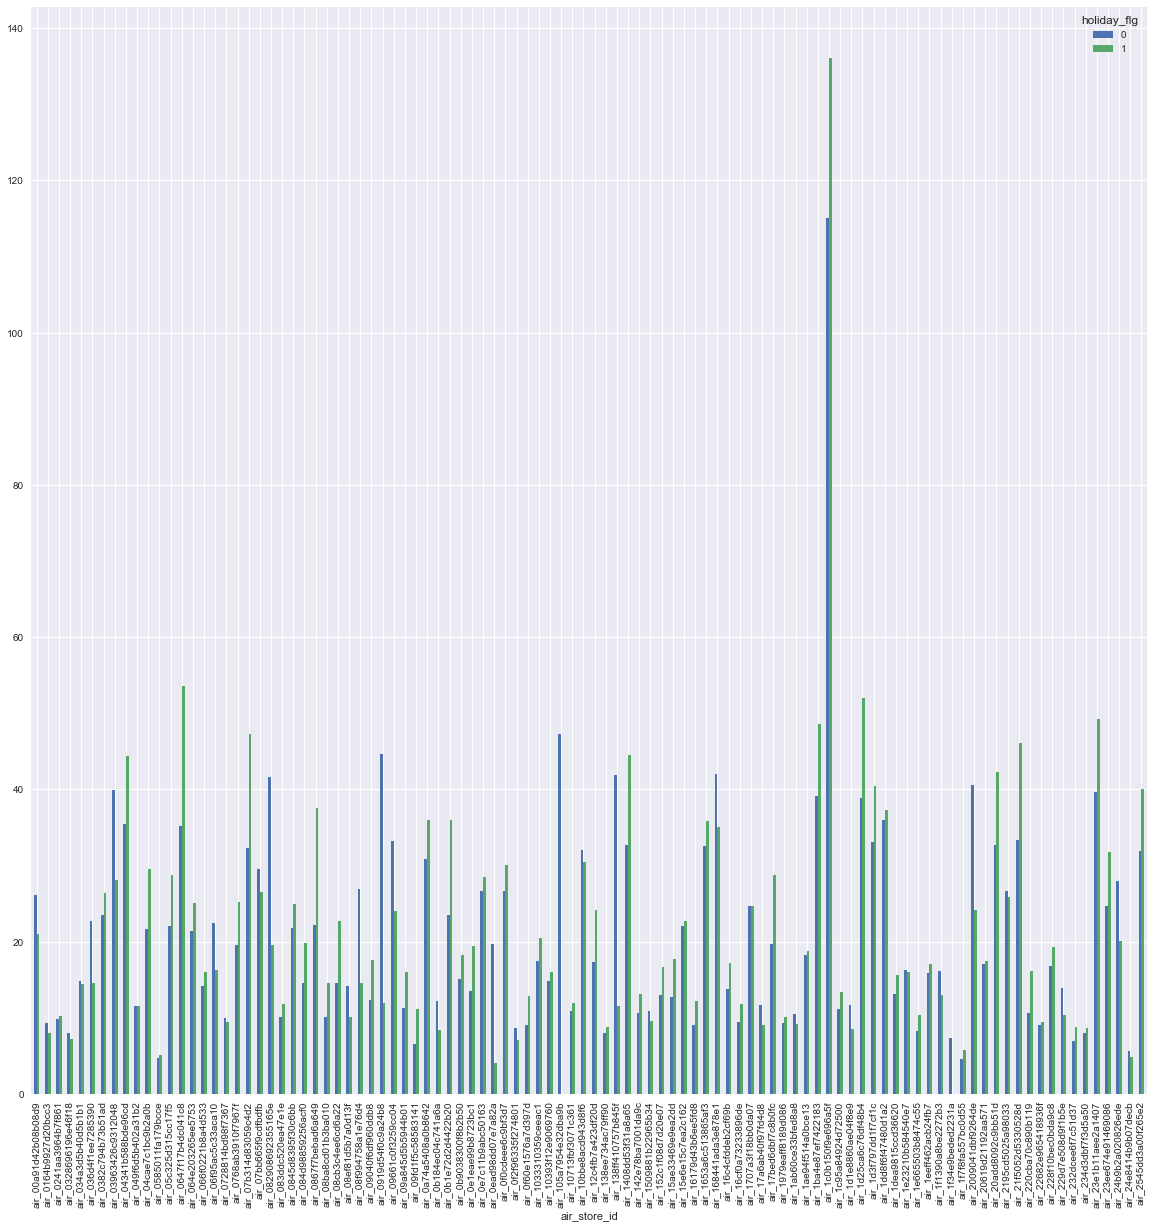

In [16]:
vis_100_cnt=visitor_cnt[:100]

vis_100_cnt.plot(kind='bar',figsize=(20,20))

* The plot shows that holiday affects the no of visitors.Based on location of the restaurant the no of visitors varies on holidays. 
* It make sense to filter no of visitors from training data only to include rows when there is no holidays,and resulting data frame is named as temp_no_holiday.


### Conversion of time series data set into supervised machine learning:
* 1.Time series problem can be framed as supervised learning problem. This will opens up a lot of linear and non linear supervised machine learning algorithm on my problem.This can be done using the previous time steps as input variable and next time step as output variable. The number of previous time steps is called the window width or size of the lag. This method referred as sliding window method for time series data.
**Reason for the conversion :**
* In timeseries forecast problem, input will be time and output will be no of visitors or amount of sales, stock value etc.
* When you are training the model to forecast no of visitors, input will be the timestamp because time stamp and no of  visitors are related but they are weakly correlated
* Using that as input and if we train the model the output produced will not be accurate. 
* To overcome this problem, instead of giving timestamp as input will replace with previous year/previous month  average no fo visitor (depending on the problem) as input which is strongly correlated with current no of visitors. If we train previous time step data as input , output produced will be accurate and model will robust by capturing the trend and seasonality in the data set.
**Framing Time series to supervised learning problem**
* The trend and seasonality pattern in the data set  can be captured in conversion by including previous year's day of the week average no of visitors. But the training data given for this problem does not have enough data to include previous year day of week  average, so I have taken previous two months day of week average no of visitors. I 
* This done using groupby in pandas and helper fucntion.
* groupby: Used to compute the every month's day of week average no of visitor for each restaurant on temp data frame. The output of groupby of temp_no_holiday data frame is stores data frame, which has following column
* 1.air_store_id	
* 2.year	
* 3.month	
* 4.dow	
* 5.avg_visitors	
* 6. avg_log_visitors
* create two copies of stores data frame and stored as stores_NH and sotres_NH_1 dataframe.
* Helper function(compute_shift(data)) : This function used to increment the  values in month column of stores_NH dataframe by 1. After incrementing 1, the values in month column incremented from 2 to 13. But month ranges from 1 to 12. values of 13 in month column should be changed to 1 and values of year in that row should also incremnted by one.It refers to first month in next year. 
* compute_shift_1(data): This function used to increment the  values in month column of stores_NH_1 dataframe by 2. After incrementing by 2, the values in month column incremented from 3 to 14. But month ranges from 1 to 12. values of  month greater than 12 is replaced with (current value of month - 12)  and values of year in that row should also incremnted by one.
* After incrementing Month and year values in stores_NH dataframe, then merging stores_NH and temp dataframe based on 'air_store_id','year','month','dow' using left join, previous month day of week average visitors will be joined to current month .ie when month 7 is incremented to 8 when we perform left join with training data based on 'air_store_id','year','month','dow',8th month day of week average is merged to 8th month dow of each restaurant in training data but that 8 month average month visitor value is actually average value of 7th month. After merging in each row you have visitors on that day plus previous month that day of week visitors average.
* After incrementing Month and year values in stores_NH_1 dataframe, then merging stores_NH_1 and temp dataframe based on 'air_store_id','year','month','dow', two month ago  day of week average visitors will be joined to current month .ie when month 7 is incremented to 9 when we perform left join with training data based on 'air_store_id','year','month','dow',9th month day of week average is merged to 9th month dow of each restaurant in training data but that 9 month average month visitor value is actually average value of 7th month. After merging in each row you have visitors on that day plus month before previous month's  day of week visitors average visitor.
* The output of above operation is stored in train dataframe. Now this dataframe holds daily no of visitors information along with previous month day of week average visitors and two months ago day of week average visitors.
* Again stores_NH and stores_NH_1 are merged with test data frame.The result of this operation is stored in test. Now this data frame has previous month's and month before previous month's day of week average no of visitors . But daily no of visitor is zero which has to be predicted.
* The merging operation mentioned above is done using left join so that training and test dataframe information is retained when the values for row in training and testing is not found in other dataframe we are merging with. These values are filled with NAN value.
* Now when training the model, input which is previous month day of week average no of visitors of current month and output will be no of visitors of current month. These arestrongly correlated.
* hence the conversion.

In [17]:
#filtering visitors of restaurants on working days
temp_no_hold=temp[temp.holiday_flg==0]
#finding average day of week in a month visitors 
stores=temp_no_hold.groupby(['air_store_id','year',
                'month','dow'],as_index=False).mean().rename(columns={'visitors':'avg_visitors','log_visitors':'avg_log_visitors'})
stores.drop(['day_of_week','holiday_flg'],axis=1,inplace=True)
stores_NH=stores.copy()
stores_NH_1=stores.copy()

In [18]:
stores.head()

,air_store_id,year,month,dow,avg_visitors,avg_log_visitors
0,air_00a91d42b08b08d9,2016,7,0,20.333333,2.995732
1,air_00a91d42b08b08d9,2016,7,1,22.500000,3.097099
2,air_00a91d42b08b08d9,2016,7,2,27.000000,3.268327
3,air_00a91d42b08b08d9,2016,7,3,35.750000,3.558768
4,air_00a91d42b08b08d9,2016,7,4,37.800000,3.605900


In [19]:
def compute_shift(data):
        return(data+1)
            
stores_NH["Month"]=stores_NH.month.apply(compute_shift)
stores_NH.head()
stores_NH.loc[(stores_NH.Month>12),'year']=stores_NH.year+1
stores_NH.loc[(stores_NH.Month>12),'Month']=stores_NH.month-12
stores_NH.drop('month',axis=1,inplace=True)
stores_NH.rename(columns={'Month':'month'},inplace=True)

stores_NH.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 65444 entries, 0 to 65443
Data columns (total 6 columns):
air_store_id        65444 non-null object
year                65444 non-null int64
dow                 65444 non-null int64
avg_visitors        65444 non-null float64
avg_log_visitors    65444 non-null float64
month               65444 non-null int64
dtypes: float64(2), int64(3), object(1)
memory usage: 3.5+ MB


In [30]:
stores_NH.head()

,air_store_id,year,dow,avg_visitors,avg_log_visitors,month
0,air_00a91d42b08b08d9,2016,0,20.333333,2.995732,8
1,air_00a91d42b08b08d9,2016,1,22.500000,3.097099,8
2,air_00a91d42b08b08d9,2016,2,27.000000,3.268327,8
3,air_00a91d42b08b08d9,2016,3,35.750000,3.558768,8
4,air_00a91d42b08b08d9,2016,4,37.800000,3.605900,8


In [20]:
def compute_shift_1(data):
        return(data+2)
            
stores_NH_1["Month"]=stores_NH_1.month.apply(compute_shift_1)
stores_NH_1.head()
stores_NH_1.loc[(stores_NH_1.Month>12),'year']=stores_NH_1.year+1
stores_NH_1.loc[(stores_NH_1.Month>12),'Month']=stores_NH_1.Month-12



In [32]:
stores_NH_1.head()

,air_store_id,year,month,dow,avg_visitors,avg_log_visitors,Month
0,air_00a91d42b08b08d9,2016,7,0,20.333333,2.995732,9
1,air_00a91d42b08b08d9,2016,7,1,22.500000,3.097099,9
2,air_00a91d42b08b08d9,2016,7,2,27.000000,3.268327,9
3,air_00a91d42b08b08d9,2016,7,3,35.750000,3.558768,9
4,air_00a91d42b08b08d9,2016,7,4,37.800000,3.605900,9


In [21]:
stores_NH_1.drop('month',axis=1,inplace=True)
stores_NH_1.rename(columns={'Month':'month'},inplace=True)

stores_NH_1.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 65444 entries, 0 to 65443
Data columns (total 6 columns):
air_store_id        65444 non-null object
year                65444 non-null int64
dow                 65444 non-null int64
avg_visitors        65444 non-null float64
avg_log_visitors    65444 non-null float64
month               65444 non-null int64
dtypes: float64(2), int64(3), object(1)
memory usage: 3.5+ MB


In [22]:
temp=pd.merge(temp,stores_NH,how='inner',on=['air_store_id','year','month','dow'])
temp.drop('day_of_week',axis=1,inplace=True)
#Preparing test and train data set
test=data['tes']
train=temp
test=pd.merge(test,stores_NH,how='left',on=['air_store_id','year','month','dow'])
train=pd.merge(train,stores_NH_1,how='inner',on=['air_store_id','year','month','dow'])
test=pd.merge(test,stores_NH_1,how='left',on=['air_store_id','year','month','dow'])

### Preparing training and testing dataset:
* Now training and testing data has previous month's average no of visitors and daily visitors count for each restaurant.
* No of visitors to restaurant also related by location, cusines. This informations are found in data['as'] data frame.
* Merging training,testing with data['as'] using left join. So training and test dataset is retained even if there is no match found in other dataframe. Those values are replaced by NAN values.
* Genre_name,area_name are categorical value which can be converted into numerical values using Label_encoder().


In [23]:

#Merging the restaurant in test and train with store information like genre, location, lattitude and longitude
test=pd.merge(test,data['as'],how='left',on=['air_store_id'])
train=pd.merge(train,data['as'],how='left',on=['air_store_id'])
encoder=LabelEncoder()

train['air_genre_name']=encoder.fit_transform(train['air_genre_name'])
test['air_genre_name']=encoder.transform(test['air_genre_name'])
train['air_area_name']=encoder.fit_transform(train['air_area_name'])
test['air_area_name']=encoder.fit_transform(test['air_area_name'])
test=pd.merge(test,data['hol'],how='left',on=['visit_date'])


In [36]:
train.head()

,air_store_id,visit_date,visitors,dow,year,month,holiday_flg,log_visitors,avg_visitors_x,avg_log_visitors_x,avg_visitors_y,avg_log_visitors_y,air_genre_name,air_area_name,latitude,longitude
0,air_ba937bf13d40fb24,2016-03-01,19,1,2016,3,0,2.944439,15.333333,2.729563,10.0,2.29756,4,62,35.658068,139.751599
1,air_ba937bf13d40fb24,2016-03-08,8,1,2016,3,0,2.079442,15.333333,2.729563,10.0,2.29756,4,62,35.658068,139.751599
2,air_ba937bf13d40fb24,2016-03-15,20,1,2016,3,0,2.995732,15.333333,2.729563,10.0,2.29756,4,62,35.658068,139.751599
3,air_ba937bf13d40fb24,2016-03-22,17,1,2016,3,0,2.833213,15.333333,2.729563,10.0,2.29756,4,62,35.658068,139.751599
4,air_ba937bf13d40fb24,2016-03-29,19,1,2016,3,0,2.944439,15.333333,2.729563,10.0,2.29756,4,62,35.658068,139.751599


In [24]:
train.rename(columns={'avg_visitors_x':'p1m_avg_visitors','avg_log_visitors_x':'p1m_avg_log_visitors','avg_visitors_y':'p2m_avg_visitors','avg_log_visitors_y':'p2m_avg_log_visitors'},inplace=True)
test.rename(columns={'avg_visitors_x':'p1m_avg_visitors','avg_log_visitors_x':'p1m_avg_log_visitors','avg_visitors_y':'p2m_avg_visitors','avg_log_visitors_y':'p2m_avg_log_visitors'},inplace=True)

In [25]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32019 entries, 0 to 32018
Data columns (total 17 columns):
id                      32019 non-null object
visitors                32019 non-null int64
visit_date              32019 non-null object
air_store_id            32019 non-null object
dow                     32019 non-null int64
year                    32019 non-null int64
month                   32019 non-null int64
p1m_avg_visitors        29759 non-null float64
p1m_avg_log_visitors    29759 non-null float64
p2m_avg_visitors        29839 non-null float64
p2m_avg_log_visitors    29839 non-null float64
air_genre_name          32019 non-null int64
air_area_name           32019 non-null int64
latitude                32019 non-null float64
longitude               32019 non-null float64
day_of_week             32019 non-null int64
holiday_flg             32019 non-null int64
dtypes: float64(6), int64(8), object(3)
memory usage: 4.4+ MB


In [26]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 187058 entries, 0 to 187057
Data columns (total 16 columns):
air_store_id            187058 non-null object
visit_date              187058 non-null object
visitors                187058 non-null int64
dow                     187058 non-null int64
year                    187058 non-null int64
month                   187058 non-null int64
holiday_flg             187058 non-null int64
log_visitors            187058 non-null float64
p1m_avg_visitors        187058 non-null float64
p1m_avg_log_visitors    187058 non-null float64
p2m_avg_visitors        187058 non-null float64
p2m_avg_log_visitors    187058 non-null float64
air_genre_name          187058 non-null int64
air_area_name           187058 non-null int64
latitude                187058 non-null float64
longitude               187058 non-null float64
dtypes: float64(7), int64(7), object(2)
memory usage: 24.3+ MB


### Handling Missing values:
In testing dataframe:
p1m_avg_visitors     :  Previous month's day of week average no of visitors.
p1m_avg_log_visitors :  Previous month day of week average no of visitors computed by log_transformed on no of visitors..  
p2m_avg_visitors      :  Two months ago day of week average no of visitors.
p2m_avg_log_visitors  :  Two months ago, day of week average no of visitors computed by log_transformed on no of visitors.
These columns in testing data set have NAN values, which is filled by following ways
* 1.Compute yearly, day of week average no of visitors of temp_no_holiday dataframe   and result is stored in avgdow_yearly dataframe.
* 2.Then merge this dataframe with test dataframe.Then fill the missing values in above columns from avg_visitors and log_avg_visitors columns of avgdow_yearly dataframe.
* After merging operation,the above four columns have NAN values but has reduced from previous count.
* To fill those miising values, compute the day of week month average no of visitors for restaurants in same area and serves same cusine using groupby in pandas.
* The result of above operation is stored as cusines dataframe. Since the average is computed monthly we will use compute_shift and compute_shift_1 function to increment month and year values. And the result is sttored as cusines_p1m and cusines_p2m dataframes.
* Then merges these dataframes with test dataframe and fill the missing value from column in test dataframe with columns from cusines_p1m and cusines_p2m dataframes.
* After filling the NAN values , columns included in test dataframe as a result of merging is dropped.
* This merging operation reduces NAN and remaing NAN is replaced with negative 1.


In [27]:
#compute yearly day of week's average number of customers.
avgdow_yearly=temp_no_hold.groupby(['air_store_id','year','dow'],as_index=False)['visitors','log_visitors'].mean().rename(columns={'visitors':'avg_visitors','log_visitors':'avg_log_visitors'})

In [28]:

#Mergin that with test data to fill mising values
test=pd.merge(test,avgdow_yearly,how='left',on=['air_store_id','year','dow'])

In [29]:
test.p1m_avg_visitors.fillna(test.avg_visitors,inplace=True)
test.p2m_avg_visitors.fillna(test.avg_visitors,inplace=True)
test.p1m_avg_log_visitors.fillna(test.avg_log_visitors,inplace=True)
test.p2m_avg_log_visitors.fillna(test.avg_log_visitors,inplace=True)
test.drop(['avg_visitors','avg_log_visitors'],axis=1,inplace=True)


In [30]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32019 entries, 0 to 32018
Data columns (total 17 columns):
id                      32019 non-null object
visitors                32019 non-null int64
visit_date              32019 non-null object
air_store_id            32019 non-null object
dow                     32019 non-null int64
year                    32019 non-null int64
month                   32019 non-null int64
p1m_avg_visitors        30948 non-null float64
p1m_avg_log_visitors    30948 non-null float64
p2m_avg_visitors        30948 non-null float64
p2m_avg_log_visitors    30948 non-null float64
air_genre_name          32019 non-null int64
air_area_name           32019 non-null int64
latitude                32019 non-null float64
longitude               32019 non-null float64
day_of_week             32019 non-null int64
holiday_flg             32019 non-null int64
dtypes: float64(6), int64(8), object(3)
memory usage: 4.4+ MB


In [31]:
#create dataframe which holds visitdate,visitors,id,genre,area name by merging temp_no_hold and data['as]
cusines=pd.merge(temp_no_hold,data['as'],how='left',on=['air_store_id'])
encoder=LabelEncoder()
#convert genre,area_name into numerical value
cusines['air_genre_name']=encoder.fit_transform(cusines['air_genre_name'])
cusines['air_area_name']=encoder.fit_transform(cusines['air_area_name'])
cusines.head()

,air_store_id,visit_date,visitors,dow,year,month,day_of_week,holiday_flg,log_visitors,air_genre_name,air_area_name,latitude,longitude
0,air_ba937bf13d40fb24,2016-01-13,25,2,2016,1,6,0,3.218876,4,62,35.658068,139.751599
1,air_ba937bf13d40fb24,2016-01-14,32,3,2016,1,4,0,3.465736,4,62,35.658068,139.751599
2,air_ba937bf13d40fb24,2016-01-15,29,4,2016,1,0,0,3.367296,4,62,35.658068,139.751599
3,air_ba937bf13d40fb24,2016-01-16,22,5,2016,1,2,0,3.091042,4,62,35.658068,139.751599
4,air_ba937bf13d40fb24,2016-01-18,6,0,2016,1,1,0,1.791759,4,62,35.658068,139.751599


In [32]:
cusines['log_visitors']=np.log(cusines.visitors)
cusines=cusines.groupby(['air_area_name','air_genre_name','year','month','dow'],as_index=False)['visitors','log_visitors'].mean().rename(columns={'visitors':'avg_visitors','log_visitors':'avg_log_visitors'})

In [33]:
#create copy of cusines dataframe
cusines_p1m=cusines.copy()
cusines_p2m=cusines.copy()

In [34]:
#function to compute previous time step
def compute_shift(data):
        return(data+1)
            
cusines_p1m["month"]=cusines_p1m.month.apply(compute_shift)
cusines_p1m.loc[(cusines_p1m.month>12),'year']=2017
cusines_p1m.loc[(cusines_p1m.month>12),'month']=cusines_p1m.month-1

In [35]:
cusines_p1m.head()

,air_area_name,air_genre_name,year,month,dow,avg_visitors,avg_log_visitors
0,0,1,2016,2,0,3.500000,0.959733
1,0,1,2016,2,1,11.105263,2.133214
2,0,1,2016,2,2,11.789474,2.215091
3,0,1,2016,2,3,10.190476,2.186920
4,0,1,2016,2,4,13.666667,2.455547


In [36]:
cusines.head()

,air_area_name,air_genre_name,year,month,dow,avg_visitors,avg_log_visitors
0,0,1,2016,1,0,3.500000,0.959733
1,0,1,2016,1,1,11.105263,2.133214
2,0,1,2016,1,2,11.789474,2.215091
3,0,1,2016,1,3,10.190476,2.186920
4,0,1,2016,1,4,13.666667,2.455547


In [37]:

cusines_p2m["month"]=cusines_p2m.month.apply(compute_shift_1)
cusines_p2m.loc[(cusines_p2m.month>12),'year']=cusines_p2m.year+1


In [38]:
cusines_p2m.loc[(cusines_p2m.month>12),'month']=cusines_p2m.month-12
cusines_p2m.head()

,air_area_name,air_genre_name,year,month,dow,avg_visitors,avg_log_visitors
0,0,1,2016,3,0,3.500000,0.959733
1,0,1,2016,3,1,11.105263,2.133214
2,0,1,2016,3,2,11.789474,2.215091
3,0,1,2016,3,3,10.190476,2.186920
4,0,1,2016,3,4,13.666667,2.455547


In [39]:
test.head()

,id,visitors,visit_date,air_store_id,dow,year,month,p1m_avg_visitors,p1m_avg_log_visitors,p2m_avg_visitors,p2m_avg_log_visitors,air_genre_name,air_area_name,latitude,longitude,day_of_week,holiday_flg
0,air_00a91d42b08b08d9_2017-04-23,0,2017-04-23,air_00a91d42b08b08d9,6,2017,4,NaN,NaN,NaN,NaN,6,44,35.694003,139.753595,3,0
1,air_00a91d42b08b08d9_2017-04-24,0,2017-04-24,air_00a91d42b08b08d9,0,2017,4,33.333333,3.438378,27.50,3.255846,6,44,35.694003,139.753595,1,0
2,air_00a91d42b08b08d9_2017-04-25,0,2017-04-25,air_00a91d42b08b08d9,1,2017,4,29.250000,3.374898,32.00,3.426816,6,44,35.694003,139.753595,5,0
3,air_00a91d42b08b08d9_2017-04-26,0,2017-04-26,air_00a91d42b08b08d9,2,2017,4,32.400000,3.397965,31.75,3.362910,6,44,35.694003,139.753595,6,0
4,air_00a91d42b08b08d9_2017-04-27,0,2017-04-27,air_00a91d42b08b08d9,3,2017,4,34.000000,3.518000,32.25,3.455870,6,44,35.694003,139.753595,4,0


In [40]:
test=pd.merge(test,cusines_p1m,how='left',on=['air_area_name','air_genre_name','year','month','dow'])
test=pd.merge(test,cusines_p2m,how='left',on=['air_area_name','air_genre_name','year','month','dow'])


In [41]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32019 entries, 0 to 32018
Data columns (total 21 columns):
id                      32019 non-null object
visitors                32019 non-null int64
visit_date              32019 non-null object
air_store_id            32019 non-null object
dow                     32019 non-null int64
year                    32019 non-null int64
month                   32019 non-null int64
p1m_avg_visitors        30948 non-null float64
p1m_avg_log_visitors    30948 non-null float64
p2m_avg_visitors        30948 non-null float64
p2m_avg_log_visitors    30948 non-null float64
air_genre_name          32019 non-null int64
air_area_name           32019 non-null int64
latitude                32019 non-null float64
longitude               32019 non-null float64
day_of_week             32019 non-null int64
holiday_flg             32019 non-null int64
avg_visitors_x          31837 non-null float64
avg_log_visitors_x      31837 non-null float64
avg_visitors_y   

In [42]:
test.p1m_avg_visitors.fillna(test.avg_visitors_x,inplace=True)
test.p1m_avg_log_visitors.fillna(test.avg_log_visitors_x,inplace=True)
test.p2m_avg_visitors.fillna(test.avg_visitors_y,inplace=True)
test.p2m_avg_log_visitors.fillna(test.avg_log_visitors_y,inplace=True)
test.drop(['avg_visitors_y','avg_log_visitors_y','avg_visitors_x','avg_log_visitors_x'],axis=1,inplace=True)
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32019 entries, 0 to 32018
Data columns (total 17 columns):
id                      32019 non-null object
visitors                32019 non-null int64
visit_date              32019 non-null object
air_store_id            32019 non-null object
dow                     32019 non-null int64
year                    32019 non-null int64
month                   32019 non-null int64
p1m_avg_visitors        31900 non-null float64
p1m_avg_log_visitors    31900 non-null float64
p2m_avg_visitors        31899 non-null float64
p2m_avg_log_visitors    31899 non-null float64
air_genre_name          32019 non-null int64
air_area_name           32019 non-null int64
latitude                32019 non-null float64
longitude               32019 non-null float64
day_of_week             32019 non-null int64
holiday_flg             32019 non-null int64
dtypes: float64(6), int64(8), object(3)
memory usage: 4.4+ MB


In [43]:
#converting str'air_Store id' into category variable of numeric
lbl =LabelEncoder()
train['air_store_id2'] = lbl.fit_transform(train['air_store_id'])
test['air_store_id2'] = lbl.fit_transform(test['air_store_id'])

col = [c for c in train if c not in ['id', 'air_store_id', 'visit_date','visitors','log_visitors','p1m_avg_visitors','p2m_avg_visitors']]


In [44]:
test=test.fillna(-1)
train[col].info()
test[col].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 187058 entries, 0 to 187057
Data columns (total 11 columns):
dow                     187058 non-null int64
year                    187058 non-null int64
month                   187058 non-null int64
holiday_flg             187058 non-null int64
p1m_avg_log_visitors    187058 non-null float64
p2m_avg_log_visitors    187058 non-null float64
air_genre_name          187058 non-null int64
air_area_name           187058 non-null int64
latitude                187058 non-null float64
longitude               187058 non-null float64
air_store_id2           187058 non-null int64
dtypes: float64(4), int64(7)
memory usage: 17.1 MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 32019 entries, 0 to 32018
Data columns (total 11 columns):
dow                     32019 non-null int64
year                    32019 non-null int64
month                   32019 non-null int64
holiday_flg             32019 non-null int64
p1m_avg_log_visitors    32019 non-n

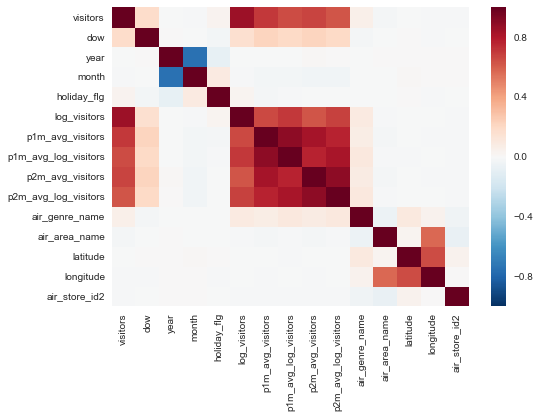

In [45]:
import seaborn as sns
corr=train.corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)


### Preparing training,validating and testing dataset for training and validating the model:
* 1.  The data is scaled to a fixed range - usually 0 to 1 using Min max scaler
* The cost of having this bounded range - in contrast to standardization - is that we will end up with smaller standard deviations, which can suppress the effect of outliers. 
* 2. Dividing the training dataset into  training(X_train,y_train) and testing(X_test and y_test).
* 3. Using Kfold cross validation, divide the training dataset into k equal folds. Then k-1 folds are chosen randomly  for 
* training and leaving one fold for validating the regression models.Repeats this process for k iteration.
* 3. Then the models performance is measured using performance metrics(Root mean square error) and takes average of the metrics and choose the model which has less value of Root mean square error will be chosen to evaluate the model using testing set. 

In [46]:
#splitting training data into X_train,X_test,y_train,y_test
X=train[col]
y=train[['log_visitors']]
from sklearn.model_selection import train_test_split,cross_val_predict
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split,cross_val_score
scaler=MinMaxScaler(feature_range=(0,1))
X=scaler.fit_transform(X)
y=scaler.fit_transform(y)
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.25,random_state=1)


In [47]:
y_train=y_train.ravel()

In [48]:
#splitting the training data into training and validation
#Parameters passed are X_train,y_train and model need this data to be trained and predicted
#function returns array of RMSE values of each iteration
from sklearn.model_selection import KFold
from sklearn.model_selection import validation_curve
from math import sqrt
def split_to_kfold(X_train,y_train,nfolds,model):
    result=[]
    fold=KFold(n_splits=nfolds,shuffle=True,random_state=1)
    for train_index,test_index in fold.split(X_train):
        model=model.fit(X_train[train_index],y_train[train_index])
        y_predict=model.predict(X_train[test_index])
        mse=mean_squared_error(y_train[test_index],y_predict)
        result.append(sqrt(mse))
    return result

    
    

### Algorithm and Its implementation:
* Time series dataset is converted into supervised regression problem. Now suites of linear and non linear regression Algorithm can be applied to this dataset.
* I have chosen following Regression Algorithm
* 1. Stocastic Gradient Descent regressor
* 2. Support vector regressor:
* 3. KNearestNeighbor regressor
* 4. Random Forest Regressor
* I have implemented using Sklearn libraries.
* Using helper function split_to_kfold, divide the data into training and validation and then using sklearn libraries, each model is implemented and trained using the fit method and yhat values are predicted and compared with actual value.
* Compute the root mean square error of predicted and actual values for every iteration and find the average RMSE.
* The model whose RMSE value is close to zero or negative value will be chosed as benchmark model.
* Then tune the hyper parameters of those models using GRIDSearchCv and find the best parameters and use those parameter to train the model and finally use test data to predict the value and measure the performance of the model. The performance of the model will improve after tuning. Then use those hyper parameters to predict the unseen data.
* After evaluating performance of all the models , Stocastic gradient Descent regressor and Support vector regressor considered to be better model for this dataset and have considered as Bench mark models.


### Bench mark model: Zero Rule Algorithm

* To know whether the predictions for above mentioned algorithms are good or not, we need to use baseline prediction algorithm.
* A baseline prediction algorithm provides a set of predictions that we I evaluate as I would any predictions for the problem, such as RMSE.
* The scores from these algorithms provide the required point of comparison when evaluating all other machine learning algorithms on my problem.
* Once established, you can comment on how much better a given algorithm is as compared to the naive baseline algorithm, providing context on just how good a given method actually is.
* The two most commonly used baseline algorithms are:
* Random Prediction Algorithm.
* Zero Rule Algorithm.
* I have chosen zero Rule Algorithm as my Bench mark model.
* The Zero Rule Algorithm is a better baseline than the random algorithm.
* It uses more information about a given problem to create one rule in order to make predictions.
* Regression problems require the prediction of a real value.
* A good default prediction for real values is to predict the central tendency. This could be the mean or the median.
* A good default is to use the mean (also called the average) of the output value observed in the training data.
* This is likely to have a lower error than random prediction which will return any observed output value.
* Below is a function to do that named zero_rule_algorithm_regression(). It works by calculating the mean value for the observed output values.
https://machinelearningmastery.com/implement-baseline-machine-learning-algorithms-scratch-python/

In [88]:
# zero rule algorithm for regression
def zero_rule_algorithm_regression(train, test):
    output_values = train
    prediction =np.mean(output_values)
    predicted = [prediction for i in range(len(test))]
    print(prediction)
    return predicted
y_predict=zero_rule_algorithm_regression(y_train,y_test)
mse=mean_squared_error(y_test,y_predict)
rmse=np.sqrt(mse)
print('RMSE of benchmark model:',rmse)

0.401614647866
RMSE of benchmark model: 0.132471734388



1.** Stochastic Gradient Descent:**
* This Algorithm finds a best fit line for the data using linear function y=mx+b.
* A standard approach to solving this type of problem is to define an error function (also called a cost function) that measures how “good” a given line is. This function will take in a (m,b) pair and return an error value based on how well the line fits our data. To compute this error for a given line, we’ll iterate through each (x,y) point in our data set and sum the square distances between each point’s y value and the candidate line’s y value (computed at mx + b). It’s conventional to square this distance to ensure that it is positive and to make our error function differentiable. 
* Lines that fit our data better (where better is defined by our error function) will result in lower error values. If we minimize this function, we will get the best line for our data
* To minimize the error, run gradient descent on the error function. To compute it, we will need to differentiate our error function. Since our function is defined by  parameters (m and b), we will need to compute a partial derivative for each.
* We can initialize our search to start at any pair of m and b values (i.e., any line) and let the gradient descent algorithm march downhill on our error function towards the best line. Each iteration will update m and b to a line that yields slightly lower error than the previous iteration. The direction to move in for each iteration is calculated using the two partial derivatives .
* The learningRate variable controls how large of a step we take downhill during each iteration. If we take too large of a step, we may step over the minimum. However, if we take small steps, it will require many iterations to arrive at the minimum.
* This hyper parameter need to be tuned to findout best value for this dataset.
* To avoid overfitting  l2 regularization is used, which will increase the penality of error function if the magnitude of fitting parameters and magnitude of lambda are high .The regularization parameter lambda is a control on your fitting parameters, which is again hyperparameter need to be tuned.

**Reason for SGD as final model:**
* The major advantage of SGD is its efficiency, which is basically linear in the number of training examples. If X is a matrix of size (n, p) training has a cost of O(k n \bar p), where k is the number of iterations (epochs) and \bar p is the average number of non-zero attributes per sample.
* Since it is faster than other algorithms, which helps in tuning the hyper parameters using gridsearch cr0ss validation to find out best combination of hyperparameters.
* It uses gradient descent to optimize the algorithm. The performance can be improved by training the data on differnet epochs , on every epochs the error is descending to lower value. This parameter is tuned usng gridsearchcv to find best number of iteration for this dataset so that error value descent to lower values.In order to avoid overfitiing L2 regularization is used.


In [49]:
#Stochastic gradient Descent for regression
from sklearn.linear_model import SGDRegressor
regressor_sgd=SGDRegressor(verbose=0,random_state=1)
scores=split_to_kfold(X_train,y_train,5,regressor_sgd)
rmse=np.mean(scores)
print('Mean squared error using kfold',scores)
print('Mean of rmse of SGD',rmse)

Mean squared error using kfold [0.09033442388864613, 0.09139446298700608, 0.09115980124150239, 0.08976348632180844, 0.09124805332589103]
Mean of rmse of SGD 0.090780045553


**KNearestNeighbor:**
* It is a non parametric model, which means it doesnot make any assumption about data distributions.
* KNN is also a lazy algorithm (as opposed to an eager algorithm).
* It means is that it does not use the training data points to do any generalization. In other words, there is no explicit training phase or it is very minimal. This also means that the training phase is pretty fast .
* Lack of generalization means that KNN keeps all the training data. 
* the training data is needed during the testing phase.KNN stores the entire training dataset which it uses as its representation.KNN does not learn any model.
* KNN Algorithm is based on feature similarity.KNN makes predictions just-in-time by calculating the similarity between an input sample and each training instance.
* The algorithm can be summarized as:
* A positive integer k is specified, along with a new sample.We select the k entries in our database which are closest to the new sample , using distance function like Euclian distance, Manhattan distance. 
* After finding k closest entries, take average of its output value and use that average as predicted value for that new sample.
* Reason for Choosing the algorithm:
The closest k sample for new sample would be highly relevant ie.The nearest data for no of visitors on specific day would be previous days no of visitors, and its previous month day of week average which are more appropriate for predicting the current day visitor count. The no of Neighbors is hyperparameter and it is given by user while training the parameter. The right number will make the model less biased and variance.
Pros:
* Insensitive to outliers — accuracy can be affected from noise or irrelevant features
* No assumptions about data — useful, for example, for nonlinear data
* Simple algorithm — to explain and understand/interpret
Cons:
* Computationally expensive — because the algorithm has to compute the distance between new sample and each training sample to find the closest training sample's output.So Prediction stage might be slow (with big N)
* High memory requirement -Stores all (or almost all) of the training data
* Sensitive to irrelevant features and the scale of the data. To avoid that feature scaling to be done.

In [64]:
#Knearest neighbor for regression
from sklearn.neighbors import KNeighborsRegressor
regressor_knn=KNeighborsRegressor(n_neighbors=8)
scores=split_to_kfold(X_train,y_train,5,regressor_knn)
rmse=np.mean(scores)
print('Mean squared error using 5fold',scores)
print('Mean of rmse of KNN using 5fold',rmse)

Mean squared error using 5fold [0.09176238525640379, 0.09301007012814008, 0.09187554072548273, 0.09096208920455963, 0.09258394140104208]
Mean of rmse of KNN using 5fold 0.0920388053431


**SVM regression:**
* 1.SVM regression works by  mapping the data x into a high-dimensional feature space F via a nonlinear mapping (Kernel tricks), and to do linear regression in this space .
* 2. Finding best hyper plane with large margin which is - epsilon insenitive zone ie trying to find the best fit so that points are closer to plane and within the zone.
* 3. SVM regression performs linear regression in the high-dimension feature space using epsilon -insensitive loss and, at the same time, tries to reduce model complexity by minimizing ||w||2. This can be described by introducing (non-negative) slack variables , to measure the deviation of training samples outside -insensitive zone epsilon.
* It is well known that SVM generalization performance (estimation accuracy) depends on a good setting of meta-parameters parameters C,  and the kernel parameters. 
* Parameter C - determines the trade off between the model complexity (flatness) and the degree to which deviations larger than  are tolerated in optimization formulation for example, if C is too large (infinity), then the objective is to minimize the empirical risk only, without regard to model complexity part in the optimization formulation.
* Parameter epsilon - controls the width of the epsilon-insensitive zone, used to fit the training data. The value of can affect the number of support vectors used to construct the regression function. The bigger , the fewer support vectors are selected. On the other hand, bigger -values results in more ‘flat’ estimates. Hence, both C and -values affect model complexity (but in a different way).
Pros:
* Kernel based framework is very powerful and flexible.
* Svm work well  with small training examples.
* Cons:
* Computational complexity : During training time, it has to do matrix computation(inner product) to map data x into high dimensional feature space.
* Learning can take very long time for large scale problem.
http://kernelsvm.tripod.com/#

In [53]:
# Support vector regressor for regression
from sklearn.svm import SVR
regressor_svm=SVR()
scores=split_to_kfold(X_train,y_train,5,regressor_svm)
rmse=np.mean(scores)
print('Mean squared errorusing kfold',scores)
print('rmse of linear regression',rmse)

Mean squared errorusing kfold [0.0897648365416425, 0.09100146824074448, 0.09045240480246867, 0.08950414992633948, 0.09076090617375704]
rmse of linear regression 0.090296753137


Random Forest:
* Random forest  build multiple CART model with different sample and different initial features. For instance, it will take a random sample of 100 observation and 5 randomly chosen initial features to build a CART model. It will repeat the process (say) 10 times and then make a final prediction on each observation. Final prediction is a function of each prediction. This final prediction can simply be the mean of each prediction.
* Each tree is built by randomly chosen features and observation, use attribute selction statistic like Gini index or information gain to compute the values for each attribute by randomly choosing split value to convert into category if it is real value.Then sort the values and the attribute which has highest value (incase of information gain) will be selcted as root for the tree and split the training data into subset . Then the  attribute which has next highest value will be child node and process repeats until leaf node has reached.
* Again no of trees to built is hyperparameter which can be tuned.
 

In [66]:
#random forest for regression
from sklearn.ensemble import RandomForestRegressor
regressor_RF=RandomForestRegressor(n_estimators=10,random_state=1)
scores=split_to_kfold(X_train,y_train,5,regressor_RF)
rmse=np.mean(scores)
print('Mean squared errorusing kfold',scores)
print('rmse of linear regression',rmse)

Mean squared errorusing kfold [0.09660743075493328, 0.09752763446247971, 0.09721947045096051, 0.09650572518620514, 0.09746113779814664]
rmse of linear regression 0.0970642797305


In [71]:
#random forest finds the features which is highly relevant has given higher score 
# in this, it has given p1mavg_log_visitors
regressor_RF.feature_importances_

array([ 0.02795843,  0.00445661,  0.03179435,  0.01418786,  0.62462819,
        0.12768851,  0.02475275,  0.02943381,  0.02912631,  0.02624638,
        0.05972681])

### Tuning the hyperparameters of SGD regressor:
 Using Gridsearch cross validation ,tunning the features penalty to avoid overfiiting, different values of alpha which controls the magnitude of the coeffecient of the features , learning rate and no of epochs.
 After training model with different values of hyper parameter, the gridsearchcv helps to find the best combination of the hyperparameters  which has less loss on the validation data.


In [133]:
from sklearn.model_selection import GridSearchCV
def SGD_parameter_tuning(X,y,nfolds):
    parameters={'penalty':('l1','l2'),'alpha':[0.001, 0.01, 0.1, 1],'n_iter':[5,15,25],'eta0':[0.01,0.1,1.0]}
    grid_search=GridSearchCV(regressor_sgd,parameters,cv=nfolds)
    grid_search.fit(X, y)
    print(grid_search.best_params_)
SGD_parameter_tuning(X_train,y_train,5)  

{'alpha': 0.001, 'eta0': 0.01, 'n_iter': 15, 'penalty': 'l2'}


### Evaluating the performance of the model with test data:
After finding the best values of hyperparameter , train the model with whole training data and predict the values of test data. Then measure the evaluation metrics ie Root mean square error .

In [50]:
#After tuning the parameter, training the model with best parameters on wholetraining set
from sklearn.model_selection import validation_curve
from sklearn.linear_model import SGDRegressor
regressor_sgd=SGDRegressor(alpha=0.001,n_iter=15,random_state=1)
regressor_sgd=regressor_sgd.fit(X_train,y_train)
y_predict=regressor_sgd.predict(X_test)
mse=mean_squared_error(y_test,y_predict)
rmse=np.sqrt(mse)
print(rmse)

0.0908786028896


In [ ]:
#OPTIONAL
# Visualize performance of model. 
xtrain=X_train[:,5]
xtest=X_test[:,5]
xtrain.shape
fig, ax = plt.subplots()
ax.scatter(xtrain, y_train, s=100, marker="x", label="data")
ax.plot(xtest,y_predict,linestyle="--", color="r", label="Fitted 1st Order Linear Model")


### Forecasting the unseen data with SGD Regressor and its tuned hyper parameter:
To predict the no of visitors of test data which model havent seen , and output of the data is not available, we have to train the model with original traaining data before spliting. and then predict the output values of unseen data.

In [51]:
#Ttaining the model with whole datset and forecast the unseen data
regressor_sgd=regressor_sgd.fit(X,y)
y_predict=regressor_sgd.predict(test[col])

C:\Users\Vidhya\Anaconda3\lib\site-packages\sklearn\utils\validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [52]:
#df dataframe holds testing dataset with predicted values.
df=test
df['visitors']=y_predict
df['visit_date']=pd.to_datetime(df.visit_date)


In [53]:

df[df.holiday_flg==0]['visitors'].describe()

count    28735.000000
mean        10.177086
std          0.820398
min          6.763301
25%          9.633256
50%         10.227338
75%         10.767375
max         12.666629
Name: visitors, dtype: float64

In [54]:
df[df.holiday_flg==1]['visitors'].describe()

count    3284.000000
mean       10.319736
std         0.778102
min         6.828047
25%         9.804823
50%        10.359249
75%        10.877407
max        12.608638
Name: visitors, dtype: float64

In [56]:
df[['id','visitors']].head(20)

,id,visitors
0,air_00a91d42b08b08d9_2017-04-23,11.410030
1,air_00a91d42b08b08d9_2017-04-24,11.536463
2,air_00a91d42b08b08d9_2017-04-25,11.572219
3,air_00a91d42b08b08d9_2017-04-26,11.570729
4,air_00a91d42b08b08d9_2017-04-27,11.660192
5,air_00a91d42b08b08d9_2017-04-28,11.702024
6,air_00a91d42b08b08d9_2017-04-29,10.892052
7,air_00a91d42b08b08d9_2017-04-30,11.410030
8,air_00a91d42b08b08d9_2017-05-01,11.452966
9,air_00a91d42b08b08d9_2017-05-02,11.566372


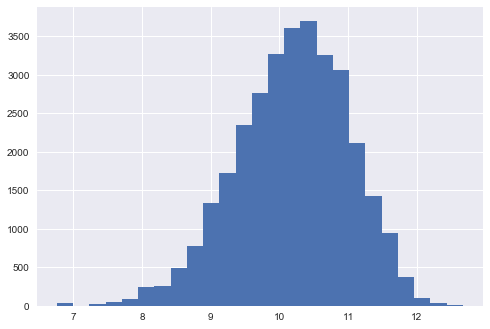

In [65]:
df.visitors.hist(bins=25)

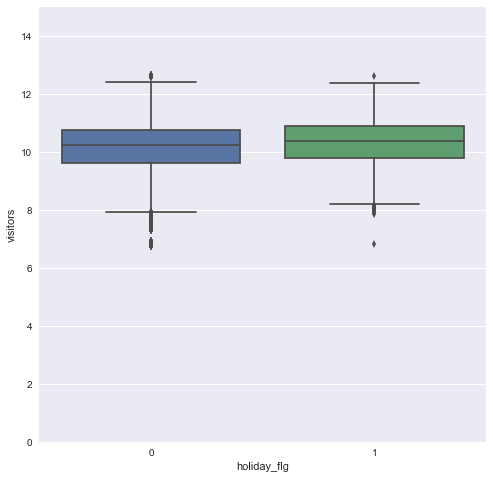

In [64]:
import seaborn as sns
plt.figure(figsize=(8,8))
plt.subplot(111)
plt.ylim(0,15)
sns.boxplot(df.holiday_flg,df.visitors)


In [73]:
df_group_holiday=df.groupby(['air_store_id','holiday_flg'],as_index=False)['visitors'].mean()


In [79]:
visitors_2017=pd.pivot_table(df_group_holiday,values='visitors',index='air_store_id',columns='holiday_flg')


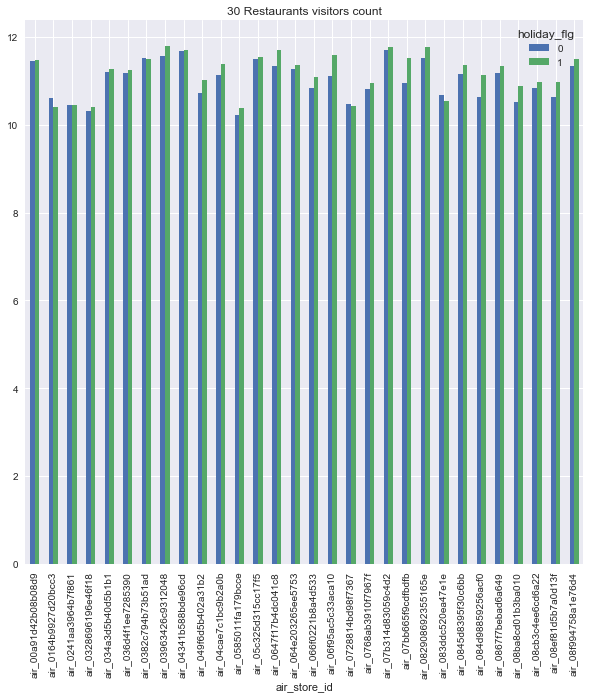

In [85]:
visitors_2017[:30].plot(kind='bar',figsize=(10,10),title='30 Restaurants visitors count')

Conclusion:
    Summary statistic and boxplot shows that no of visitors during holiday is high. That pattern in dataset has been captured in mapping function and that is relationship is observed on unseen dataset aswell.